# Drift Dispersion Relation Solver by Superstatistics Integral(Kappa Distribution)-Fig2

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
import plasmapy
from scipy import special as sp
import scipy.optimize as op
from scipy import integrate
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
def PDRM(w2wc,ky_rho_i,kz_rho_i):
    Te2Ti = ve2vi**2/mi2me
    ky_rho_e = ky_rho_i*np.sqrt(Te2Ti/mi2me)
    kz_rho_e = kz_rho_i*np.sqrt(Te2Ti/mi2me)
    ky2kz = ky_rho_i/kz_rho_i
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*np.sqrt(Te2Ti)
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/np.sqrt(mi2me)/np.sqrt(Te2Ti)
    zeta_ni = 1.0/Ln2rho_i/np.sqrt(2)*ky2kz
    zeta_ne = -zeta_ni*np.sqrt(Te2Ti)/np.sqrt(mi2me)
    
    re = 1 + (zeta_e-zeta_ne)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*np.i0(ky_rho_e**2)*np.exp(-ky_rho_e**2)
    ri = 1 + (zeta_i-zeta_ni)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*np.i0(ky_rho_i**2)*np.exp(-ky_rho_i**2)
    r = 1 + re/k_l_De**2 + ri/k_l_Di**2
    return [r.real,r.imag]

def PDRK(w2wc,ky_rho_i,kz_rho_i):
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    kz_rho_e = kz_rho_i*ve2vi/mi2me
    ky2kz = ky_rho_i/kz_rho_i
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*np.sqrt(kappa_i/(kappa_i-0.5))
    k_l_De = k_l_Di*np.sqrt(ve2vi**2/mi2me/ae2ai*he2hi)
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 1.0/Ln2rho_i/np.sqrt(2)*ky2kz*kappa_i/(kappa_i-1.5)
    zeta_ne = -zeta_ni*ve2vi/mi2me/ae2ai
    
    integrad_e1 = lambda be: np.sqrt(be)*zeta_e *plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*np.i0(ky_rho_e**2/be)*np.exp(-ky_rho_e**2/be)
    integrad_e2 = lambda be: np.sqrt(be)*zeta_ne*plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*np.i0(ky_rho_e**2/be)*np.exp(-ky_rho_e**2/be)
    integrad_i1 = lambda bi: np.sqrt(bi)*zeta_i *plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*np.i0(ky_rho_i**2/bi)*np.exp(-ky_rho_i**2/bi)
    integrad_i2 = lambda bi: np.sqrt(bi)*zeta_ni*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*np.i0(ky_rho_i**2/bi)*np.exp(-ky_rho_i**2/bi)
    
    terms = 100
    gl_e1 = sp.roots_genlaguerre(terms,kappa_e-0.5)
    gl_e2 = sp.roots_genlaguerre(terms,kappa_e-1.5)
    gl_i1 = sp.roots_genlaguerre(terms,kappa_i-0.5)
    gl_i2 = sp.roots_genlaguerre(terms,kappa_i-1.5)
    
    i_e1 = np.dot(gl_e1[1],integrad_e1(gl_e1[0]/kappa_e))/sp.gamma(kappa_e+0.5)
    i_e2 = np.dot(gl_e2[1],integrad_e2(gl_e2[0]/kappa_e))/sp.gamma(kappa_e+0.5)*(kappa_e-1.5)
    i_i1 = np.dot(gl_i1[1],integrad_i1(gl_i1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    i_i2 = np.dot(gl_i2[1],integrad_i2(gl_i2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)
    
    re = 1 + i_e1-i_e2
    ri = 1 + i_i1-i_i2
    r = 1 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

In [4]:
mi2me = 1836
ve2vi = 100

Ln2rho_i = 10
wp_i2wc_i = 100

In [5]:
kappa_e = 3.0
kappa_i = 3.0

ae2ai = (kappa_e-1.5)/kappa_e * kappa_i/(kappa_i-1.5)
he2hi = (kappa_e-1.5)/(kappa_e-0.5) * (kappa_i-0.5)/(kappa_i-1.5)

In [6]:
kytest = 1e-3
kztest = 1e-4

#for ky_rho_i = 1e-3 kz_rho_i = 1e-3 kappa_e = kappa_i = 3
# wguess_m = -0.004
# rguess_m = -0.0001
# wguess_k = -0.004
# rguess_k = -0.0001
wguess_m = -0.0007
rguess_m = -1e-5
wguess_k = -0.00065
rguess_k = -1e-5

s=op.root(lambda w:PDRM(w,kytest,kztest),[wguess_m,rguess_m])
print('M',s.success)
print(s.x[0],s.x[1])

s1=op.root(lambda w:PDRK(w,kytest,kztest),[wguess_k,rguess_k])
print('K',s1.success)
print(s1.x[0],s1.x[1])

M True
-0.0006491331489604589 -7.031490410457486e-06
K True
-0.0007739758406828547 -2.4773048089321264e-05


In [7]:
ky_rho_i_list = np.linspace(1e-3,8e-1,num=55)
kz_rho_i_list = np.linspace(5e-4,5e-2,num=600)

In [8]:
r_m = []

wgk =wguess_k
rgk =rguess_k
for kzi in tqdm(kz_rho_i_list):
    w_K_list = []
    r_K_list = []
    for kyi in ky_rho_i_list:
        sK=op.root(lambda w:PDRK(w,kyi,kzi),[wgk,rgk])
        if sK.success==True:
            wgk = sK.x[0]
            rgk = sK.x[1]
            w_K_list.append(sK.x[0])
            r_K_list.append(sK.x[1])
        else:
            sK2=op.root(lambda w:PDRK(w,kyi,kzi),[w_K_list[-2],r_K_list[-2]])
            wgk = sK2.x[0]
            rgk = sK2.x[1]
            w_K_list.append(sK2.x[0])
            r_K_list.append(sK2.x[1])
    r_m.append(r_K_list)
    wgk = round(w_K_list[0],6)
    rgk = round(r_K_list[0],6)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [07:22<00:00,  1.36it/s]


In [9]:
cond_u = (kappa_i-1.5)/kappa_i
cond_d = 2*kappa_e+(2*kappa_e-3)*(ve2vi**2/mi2me/ae2ai)
ky_rho_i_cond_K = np.sqrt(cond_u/cond_d)
print('K',ky_rho_i_cond_K)

K 0.14960451081023216


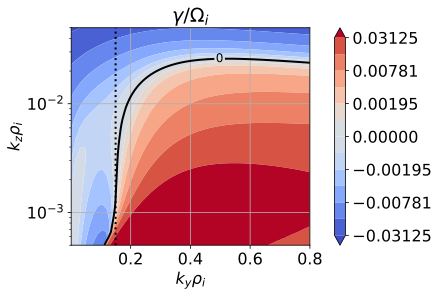

In [10]:
KY,KZ=np.meshgrid(ky_rho_i_list,kz_rho_i_list)
fig = plt.figure(figsize=(6,4),layout='constrained')
CF= plt.contourf(KY,KZ,r_m,levels=15,cmap=plt.cm.coolwarm,extend='both',vmin=np.min(r_m), vmax=np.max(r_m),
                 locator=ticker.SymmetricalLogLocator(base=2, linthresh=1e-3),
                 norm=colors.SymLogNorm(linthresh=1e-3, linscale=0.05,vmin=np.min(r_m), vmax=np.max(r_m), base=10)
                )
C = plt.contour(KY,KZ,r_m,levels=[0.0],colors='black')
plt.clabel(C, inline=True, fontsize=12, manual = [(0.5,0.02)])
plt.axvline(ky_rho_i_cond_K,color='black',linestyle=':')
# plt.text(0.11,7e-4,r'$K_y$')
plt.xlabel(r'$k_y\rho_i$')
plt.ylabel(r'$k_z\rho_i$')
plt.yscale('log')
cbar = fig.colorbar(CF)
plt.grid()
plt.title(r'$\gamma/\Omega_i$')
plt.savefig('./fig2_gamma_vs_kykz_kpe=3_kpi=3.pdf')
plt.show()